# IMSPY DDA as Jupyter Notebook

This notebook breaks down the `imspy_dda` command line tool into its key components. It allows users to dive into the code, play with settings, exchange parts etc. You will:

* Read the PASEF fragment data from disk into memory
* Pre-process the data to make it compatible with sagepy
* Configure sagepy for searching
* Score the extracted spectra
* Calculate q-values on PSM and Peptide level with TDC
* Calibrate mz values
* Calibrate collision energies for intensity prediction
* Predict fragment intensities, retention times, and ion-mobilities
* Re-score PSMs with predicted features
* Look at performance of different re-scoring engines

We hope you enjoy this resource, if you encounter bugs or problems don't hesitate to reach out on GitHub.

### Data read-in

In [1]:
from imspy.timstof.dda import TimsDatasetDDA

ds_name = 'M210115_001_Slot1-1_1_850'
dataset = TimsDatasetDDA('/media/hd01/CCSPred/HELA-GRAD110/M210115_001_Slot1-1_1_850.d/', in_memory=False)

2024-10-15 16:37:10.635517: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-15 16:37:10.635546: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-15 16:37:10.639359: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-15 16:37:10.655996: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-15 16:37:11.415891: W tensorflow/compiler/tf2

### Extract PASEF fragments

In [2]:
# read the PASEF fragments into RAM
fragments = dataset.get_pasef_fragments()

# accumulate re-fragmented frames, since PASEF re-fragments ions below a certain intensity thershold
fragments = fragments.groupby('precursor_id').agg({
    'frame_id': 'first',
    'time': 'first',
    'precursor_id': 'first', 
    'raw_data': 'sum',
    'scan_begin': 'first',
    'scan_end': 'first',
    'isolation_mz': 'first',
    'isolation_width': 'first',
    'collision_energy': 'first',
    'largest_peak_mz': 'first',
    'average_mz': 'first',
    'monoisotopic_mz': 'first',
    'charge': 'first',
    'average_scan': 'first',
    'intensity': 'first',
    'parent_id': 'first',
})

### Make a quick visualization of extracted fragment information

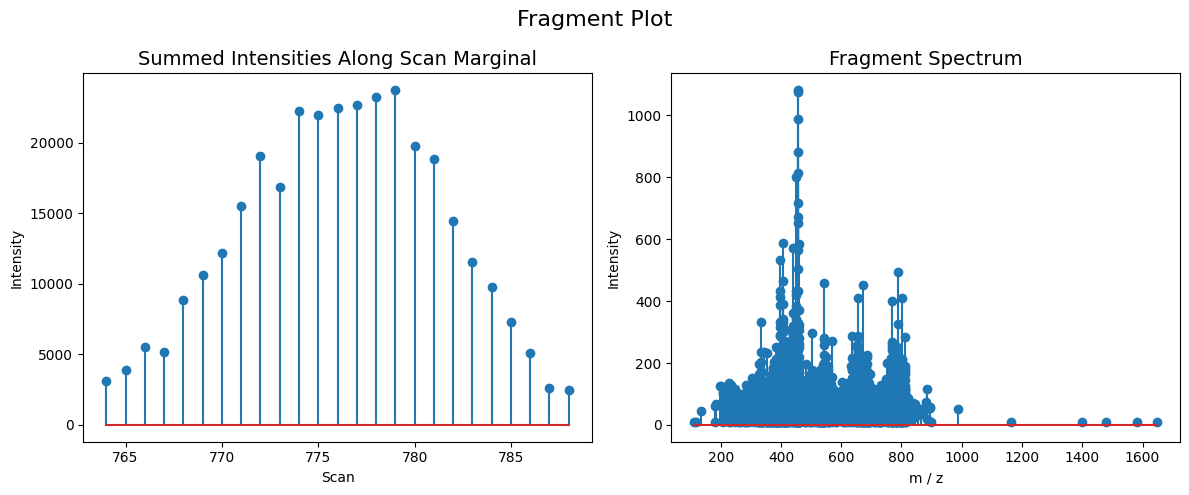

In [3]:
from matplotlib import pyplot as plt

# Visualize a fragment, e.g., look at scan marginal
# You can look at different fragment spectra by changing the index
one_fragment = fragments.raw_data.values[3223]

# sum along scan marginal and visualize
scan_marginal_df = one_fragment.df.groupby('scan').agg({
    'intensity': 'sum'
}).reset_index()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), dpi=100)

# Plot the scan marginal on the first panel
ax1.stem(scan_marginal_df['scan'], scan_marginal_df['intensity'])
ax1.set_title("Summed Intensities Along Scan Marginal", fontsize=14)
ax1.set_xlabel("Scan")
ax1.set_ylabel("Intensity")

# Plot the spectrum on the second panel
ax2.stem(one_fragment.df['mz'], one_fragment.df['intensity'])
ax2.set_title("Fragment Spectrum", fontsize=14)
ax2.set_xlabel("m / z")
ax2.set_ylabel("Intensity")
#ax2.set_xlim(200, 1500)

# Add an overall title
fig.suptitle("Fragment Plot", fontsize=16)

plt.tight_layout()
plt.show()

### Add marginal maximum ion-mobility to the dataframe, this will help with ion-mobility prediction later

In [4]:
# this data lacks summarized ion-mobility information (point estimate), which can be extracted and added to the df
mobility = fragments.apply(lambda r: r.raw_data.get_inverse_mobility_along_scan_marginal(), axis=1)
fragments['mobility'] = mobility

# also, add a spectrum id for processing of spectra with 
spec_id = fragments.apply(lambda r: str(r['frame_id']) + '-' + str(r['precursor_id']) + '-' + ds_name, axis=1)
fragments['spec_id'] = spec_id

### Create sagepy compatible representation

In [5]:
from imspy.timstof.dbsearch.utility import sanitize_mz, sanitize_charge, get_searchable_spec
from sagepy.core import Precursor, RawSpectrum, ProcessedSpectrum, SpectrumProcessor, Tolerance, Scorer, Representation

# create a precursor object
sage_precursor = fragments.apply(lambda r: Precursor(
    mz=sanitize_mz(r['monoisotopic_mz'], r['largest_peak_mz']), 
    intensity=r['intensity'],
    charge=sanitize_charge(r['charge']),
    isolation_window=Tolerance(da=(-3, 3)),
    collision_energy=r.collision_energy,
    inverse_ion_mobility=r.mobility,
), axis=1)

# add the precursor object to the df
fragments['sage_precursor'] = sage_precursor

In [6]:
# create a searchable fragment spectrum, which is a combination of the precursor info and fragment spectrum
processed_spec = fragments.apply(
    lambda r: get_searchable_spec(
        precursor=r.sage_precursor,
        raw_fragment_data=r.raw_data,
        spec_processor=SpectrumProcessor(take_top_n=150),
        spec_id=r.spec_id,
        time=r['time'],
    ),
    axis=1
)

# add the spectra to the data frame
fragments['processed_spec'] = processed_spec

### Configure sagepy to perform a search

In [7]:
from sagepy.core import EnzymeBuilder

# configure a trypsin-like digestor of fasta files
enzyme_builder = EnzymeBuilder(
    missed_cleavages=2, 
    min_len=7,
    max_len=30,
    cleave_at='KR', 
    restrict='P',
    c_terminal=True,
)

# Static modifications
static_modifications = {
    "C": "[UNIMOD:4]",
}

# Variable mods need to take a list
variable_modifications = {
    "M": ["[UNIMOD:35]"],
    "[": ["[UNIMOD:1]"]
}

In [8]:
# read a reference fasta file of a proteome, in this case human proteome since this tutorial used HeLa data
path = '/media/hd02/data/fasta/hela/plain/uniprotkb_proteome_UP000005640_AND_revi_2024_05_21.fasta'

with open(path, 'r') as infile:
    fasta = infile.read()

In [9]:
import numpy as np
from sagepy.core import SageSearchConfiguration

# set-up a config for a sage-database
sage_config = SageSearchConfiguration(
    fasta=fasta,
    static_mods=static_modifications,
    variable_mods=variable_modifications,
    enzyme_builder=enzyme_builder,
    generate_decoys=True,
    fragment_min_mz=150,
    fragment_max_mz=1700,
    bucket_size=int(np.power(2, 14)),
    keep_ends=True,
    shuffle_decoys=False,
)

# generate the database for searching against
indexed_db = sage_config.generate_indexed_database()

In [10]:
# create a scorer object that can be used to search a database given a collection of spectra to search
scorer = Scorer(
    precursor_tolerance=Tolerance(ppm=(-15.0, 15.0)),
    fragment_tolerance=Tolerance(ppm=(-25.0, 25.0)),
    report_psms=5,
    min_matched_peaks=5,
    annotate_matches=True,
    static_mods=static_modifications,
    variable_mods=variable_modifications,
)

### Search a database

In [11]:
# scoring the results
psm_collection = scorer.score_collection_psm(
    db=indexed_db, 
    spectrum_collection=fragments['processed_spec'].values,  
    num_threads=16,
)

### Create a pandas DataFrame from the PSMs

In [12]:
from sagepy.utility import peptide_spectrum_match_collection_to_pandas
PSM_pandas = peptide_spectrum_match_collection_to_pandas(psm_collection)

PSM_pandas

,spec_idx,match_idx,proteins,decoy,score,re_score,hyper_score,rank,mono_mz_calculated,mono_mass_observed,...,median_ppm,fragments_observed,fragments_predicted,projected_rt,beta_score,posterior_error_prob,spectral_entropy_similarity,spectral_correlation_similarity_pearson,spectral_correlation_similarity_spearman,spectral_normalized_intensity_difference
0,1000-1127-M210115_001_Slot1-1_1_850,IVEAANKK,[sp|Q8N183|NDUF2_HUMAN],False,14.069781,None,14.069781,1,436.763641,871.511353,...,-7.604881,"Fragments(charges: [1, 1, 1, 1, 1, 1, 1], ion_...",None,None,None,None,None,None,None,None
1,1000-1127-M210115_001_Slot1-1_1_850,KAAAAAGGKK,[sp|Q9ULW3|ABT1_HUMAN],False,9.271624,None,9.271624,2,436.769257,871.511353,...,-10.108868,"Fragments(charges: [1, 1, 1, 1, 1], ion_types:...",None,None,None,None,None,None,None,None
2,10000-23074-M210115_001_Slot1-1_1_850,MDKVEDELKEK,[sp|Q14683|SMC1A_HUMAN],False,20.263468,None,20.263468,1,682.342346,1362.668335,...,-4.599133,"Fragments(charges: [1, 1, 1, 1, 1, 1, 1, 1, 1,...",None,None,None,None,None,None,None,None
3,10000-23074-M210115_001_Slot1-1_1_850,EEKSEKMVQQK,[sp|O60293|ZC3H1_HUMAN],True,9.110299,None,9.110299,2,682.347961,1362.668335,...,-1.792640,"Fragments(charges: [1, 1, 1, 1, 1], ion_types:...",None,None,None,None,None,None,None,None
4,10000-23075-M210115_001_Slot1-1_1_850,SLQAVPGAK,[sp|P58107|EPIPL_HUMAN],False,14.439822,None,14.439822,1,435.755798,869.496277,...,-0.777880,"Fragments(charges: [1, 1, 1, 1, 1, 1, 1, 1], i...",None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
189717,9998-23071-M210115_001_Slot1-1_1_850,VQQLVPK,[sp|O43707|ACTN4_HUMAN],False,15.045572,None,15.045572,1,406.255432,810.496765,...,-3.242864,"Fragments(charges: [1, 1, 1, 1, 1, 1, 1, 1], i...",None,None,None,None,None,None,None,None
189718,9998-23071-M210115_001_Slot1-1_1_850,QLVQPPK,"[sp|P42226|STAT6_HUMAN, sp|P42229|STA5A_HUMAN,...",True,14.348376,None,14.348376,2,405.247620,810.496765,...,-8.649132,"Fragments(charges: [1, 1, 1, 1, 1, 1, 1, 1], i...",None,None,None,None,None,None,None,None
189719,9998-23071-M210115_001_Slot1-1_1_850,LARQPPK,[sp|Q8N1G1|REXO1_HUMAN],False,12.805788,None,12.805788,3,405.253235,810.496765,...,-8.943710,"Fragments(charges: [1, 1, 1, 1, 1, 1, 1], ion_...",None,None,None,None,None,None,None,None
189720,9998-23071-M210115_001_Slot1-1_1_850,ARIVQPK,[sp|Q96L96|ALPK3_HUMAN],True,10.318507,None,10.318507,4,406.261078,810.496765,...,-4.187071,"Fragments(charges: [1, 1, 1, 1, 1], ion_types:...",None,None,None,None,None,None,None,None


### Apply mz calibration

In [13]:
from sagepy.utility import apply_mz_calibration

# mz calibration is applied by moving all mz values by the mean or median mass error given by the db search
# the function will extract statistically certain hits (q-value 0.01) to estimate a global ppm error for the experiment
ppm_error = apply_mz_calibration(psm_collection, fragments)

# add global ppm error to psms
for _, values in psm_collection.items():
    for value in values:
        value.file_name = ds_name
        value.mz_calibration_ppm = ppm_error

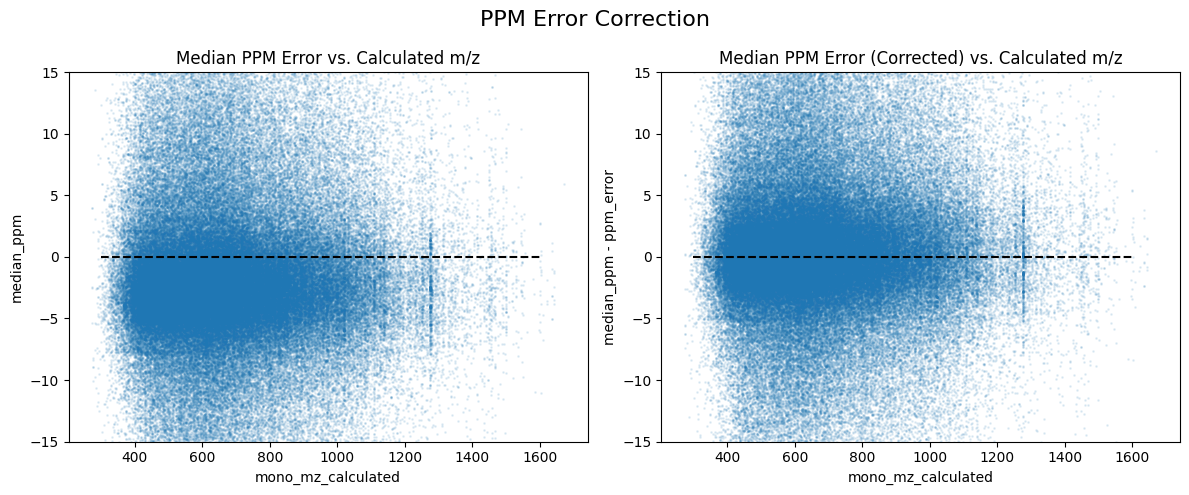

In [14]:
from sagepy.utility import calculate_ppm_error

# Create a two-panel figure
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), dpi=100)

# Plot 1: median_ppm
ax1.scatter(PSM_pandas.mono_mz_calculated, PSM_pandas.median_ppm, s=1, alpha=0.1)
ax1.set_ylim(-15, 15)
ax1.hlines(0, 300, 1600, color="black", linestyle="dashed")
ax1.set_title("Median PPM Error vs. Calculated m/z")
ax1.set_xlabel("mono_mz_calculated")
ax1.set_ylabel("median_ppm")

# Plot 2: median_ppm - ppm_error
ax2.scatter(PSM_pandas.mono_mz_calculated, PSM_pandas.median_ppm - ppm_error, s=1, alpha=0.1)
ax2.set_ylim(-15, 15)
ax2.hlines(0, 300, 1600, color="black", linestyle="dashed")
ax2.set_title("Median PPM Error (Corrected) vs. Calculated m/z")
ax2.set_xlabel("mono_mz_calculated")
ax2.set_ylabel("median_ppm - ppm_error")

# Add an overall title
fig.suptitle("PPM Error Correction", fontsize=16)

plt.tight_layout()
plt.show()

### Calculate collision energy calibration factor for PROSIT

2024-10-15 16:39:43.547431: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-10-15 16:39:43.681900: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-10-15 16:39:43.684693: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Searching for collision energy calibration factor between -30 and 30 ...


calibrating CE:   0%|                                                        | 0/60 [00:00<?, ?it/s]2024-10-15 16:39:47.602803: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
2024-10-15 16:39:47.741705: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
/home/administrator/Documents/promotion/ENV-11/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/administrator/Documents/promotion/ENV-11/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
calibrating CE: 100%|███████████████████████████████████████████████| 60/60 [00:25<00:00,  2.31it/s]


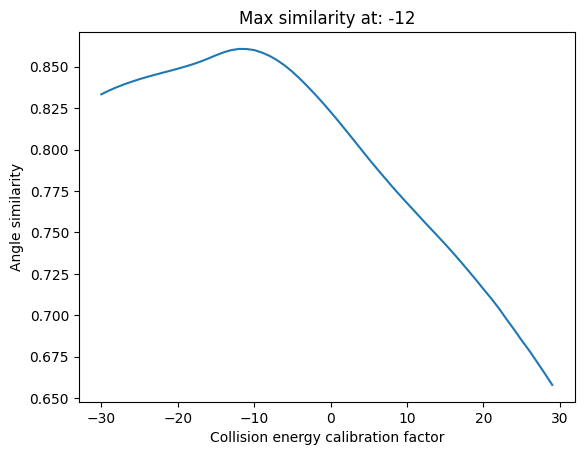

In [15]:
from imspy.algorithm.intensity.predictors import Prosit2023TimsTofWrapper, get_collision_energy_calibration_factor

psm_list = []

for k, values in psm_collection.items():
    psm_list.extend(values)

# take the top-n scoring PSMs to calibrate collision energy
sample = sorted(psm_list, key=lambda s: s.hyper_score)[-4096:]

# load prosit model
prosit_model = Prosit2023TimsTofWrapper(verbose=False)

# calculate the calibration factor
collision_energy_calibration_factor, angles = get_collision_energy_calibration_factor(
    sample, 
    prosit_model, 
    verbose=True
)

# add the calibration factor to the PSMs
for k, values in psm_collection.items():
    for p in values:
        p.collision_energy_calibrated = p.collision_energy + collision_energy_calibration_factor

# plot the results
plt.title(f"Max similarity at: {collision_energy_calibration_factor}")
plt.plot(np.arange(-30, 30), angles)
plt.xlabel("Collision energy calibration factor")
plt.ylabel("Angle similarity")
plt.show()

### Predict intensities

In [16]:
from imspy.algorithm.intensity.predictors import associate_fragment_ions_with_prosit_predicted_intensities

psms = []

# for easier handling, create a list of psms instead of a dict
for k, v in psm_collection.items():
    psms.extend(v)

# predict the intensity values, 
I = prosit_model.predict_intensities(
    [p.sequence for p in psms],
    np.array([p.charge for p in psms]),
    [p.collision_energy_calibrated for p in psms],
    batch_size=2048,
    flatten=True,
)

# add intensity values to PSMs
psms = associate_fragment_ions_with_prosit_predicted_intensities(psms, I, num_threads=16)

In [17]:
from imspy.algorithm.utility import load_tokenizer_from_resources
from imspy.algorithm.ccs.predictors import load_deep_ccs_predictor, DeepPeptideIonMobilityApex
from imspy.algorithm.rt.predictors import load_deep_retention_time_predictor, DeepChromatographyApex


im_predictor = DeepPeptideIonMobilityApex(load_deep_ccs_predictor(), 
                                          load_tokenizer_from_resources("tokenizer-ptm"))

rt_predictor = DeepChromatographyApex(load_deep_retention_time_predictor(), 
                                      load_tokenizer_from_resources("tokenizer-ptm"), verbose=True)

In [18]:
from imspy.timstof.dbsearch.utility import generate_balanced_im_dataset

# fit ion mobility predictor
im_predictor.fine_tune_model(
    data=peptide_spectrum_match_collection_to_pandas(generate_balanced_im_dataset(psms=psms)),
    batch_size=1024,
    re_compile=True,
    verbose=False,
)

2024-10-15 16:40:51.140097: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f6284bf5e00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-10-15 16:40:51.140127: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 2070, Compute Capability 7.5
2024-10-15 16:40:51.154347: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1729003251.227816  199903 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


In [19]:
# predict ion mobilities
inv_mob = im_predictor.simulate_ion_mobilities(
    sequences=[x.sequence for x in psms],
    charges=[x.charge for x in psms],
    mz=[x.mono_mz_calculated for x in psms]
)

# set ion mobilities
for mob, p in zip(inv_mob, psms):
    p.inverse_mobility_predicted = mob

### Project observed retention time into range 0, 60

In [20]:
from imspy.algorithm.rt.predictors import linear_map

# extract min and max rt values
rt_min = dataset.meta_data.Time.min() / 60.0
rt_max = dataset.meta_data.Time.max() / 60.0

# map the observed retention time into the domain [0, 60]
for value in psms:
    value.projected_rt = linear_map(value.retention_time_observed, rt_min, rt_max, 0.0, 60.0)

### Predict retention times

In [21]:
from imspy.timstof.dbsearch.utility import generate_balanced_rt_dataset

# fit retention time predictor
rt_predictor.fine_tune_model(
    data=peptide_spectrum_match_collection_to_pandas(generate_balanced_rt_dataset(psms=psms)),
    batch_size=1024,
    re_compile=True,
    verbose=False,
)

In [22]:
# predict retention times
rt_pred = rt_predictor.simulate_separation_times(
    sequences=[x.sequence for x in psms],
)

# set retention times
for rt, p in zip(rt_pred, psms):
    p.retention_time_predicted = rt

186/186 [==============================] - 3s 13ms/step


In [23]:
# create pandas table from psms
PSM_pandas = peptide_spectrum_match_collection_to_pandas(psms)

# have a look at the generated table which now contains a lot more features per PSM
PSM_pandas

,spec_idx,match_idx,proteins,decoy,score,re_score,hyper_score,rank,mono_mz_calculated,mono_mass_observed,...,median_ppm,fragments_observed,fragments_predicted,projected_rt,beta_score,posterior_error_prob,spectral_entropy_similarity,spectral_correlation_similarity_pearson,spectral_correlation_similarity_spearman,spectral_normalized_intensity_difference
0,1000-1127-M210115_001_Slot1-1_1_850,IVEAANKK,[sp|Q8N183|NDUF2_HUMAN],False,14.069781,None,14.069781,1,436.763641,871.511353,...,-7.604881,"Fragments(charges: [1, 1, 1, 1, 1, 1, 1], ion_...","Fragments(charges: [1, 1, 1, 1, 1, 1, 1], ion_...",0.883805,None,None,0.900548,0.986612,0.740839,None
1,1000-1127-M210115_001_Slot1-1_1_850,KAAAAAGGKK,[sp|Q9ULW3|ABT1_HUMAN],False,9.271624,None,9.271624,2,436.769257,871.511353,...,-10.108868,"Fragments(charges: [1, 1, 1, 1, 1], ion_types:...","Fragments(charges: [1, 1, 1, 1, 1], ion_types:...",0.883805,None,None,0.296897,-0.067115,0.085471,None
2,10000-23074-M210115_001_Slot1-1_1_850,MDKVEDELKEK,[sp|Q14683|SMC1A_HUMAN],False,20.263468,None,20.263468,1,682.342346,1362.668335,...,-4.599133,"Fragments(charges: [1, 1, 1, 1, 1, 1, 1, 1, 1,...","Fragments(charges: [1, 1, 1, 1, 1, 1, 1, 1, 1,...",8.834607,None,None,0.692286,0.461689,0.571864,None
3,10000-23074-M210115_001_Slot1-1_1_850,EEKSEKMVQQK,[sp|O60293|ZC3H1_HUMAN],True,9.110299,None,9.110299,2,682.347961,1362.668335,...,-1.792640,"Fragments(charges: [1, 1, 1, 1, 1], ion_types:...","Fragments(charges: [1, 1, 1, 1, 1], ion_types:...",8.834607,None,None,-0.025995,-0.089372,0.089645,None
4,10000-23075-M210115_001_Slot1-1_1_850,SLQAVPGAK,[sp|P58107|EPIPL_HUMAN],False,14.439822,None,14.439822,1,435.755798,869.496277,...,-0.777880,"Fragments(charges: [1, 1, 1, 1, 1, 1, 1, 1], i...","Fragments(charges: [1, 1, 1, 1, 1, 1, 1, 1], i...",8.834607,None,None,0.771082,0.704703,0.657965,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
189717,9998-23071-M210115_001_Slot1-1_1_850,VQQLVPK,[sp|O43707|ACTN4_HUMAN],False,15.045572,None,15.045572,1,406.255432,810.496765,...,-3.242864,"Fragments(charges: [1, 1, 1, 1, 1, 1, 1, 1], i...","Fragments(charges: [1, 1, 1, 1, 1, 1, 1, 1], i...",8.832837,None,None,0.934301,0.841769,0.880623,None
189718,9998-23071-M210115_001_Slot1-1_1_850,QLVQPPK,"[sp|P42226|STAT6_HUMAN, sp|P42229|STA5A_HUMAN,...",True,14.348376,None,14.348376,2,405.247620,810.496765,...,-8.649132,"Fragments(charges: [1, 1, 1, 1, 1, 1, 1, 1], i...","Fragments(charges: [1, 1, 1, 1, 1, 1, 1, 1], i...",8.832837,None,None,0.661225,0.335653,0.772603,None
189719,9998-23071-M210115_001_Slot1-1_1_850,LARQPPK,[sp|Q8N1G1|REXO1_HUMAN],False,12.805788,None,12.805788,3,405.253235,810.496765,...,-8.943710,"Fragments(charges: [1, 1, 1, 1, 1, 1, 1], ion_...","Fragments(charges: [1, 1, 1, 1, 1, 1, 1], ion_...",8.832837,None,None,0.650327,0.127021,0.586624,None
189720,9998-23071-M210115_001_Slot1-1_1_850,ARIVQPK,[sp|Q96L96|ALPK3_HUMAN],True,10.318507,None,10.318507,4,406.261078,810.496765,...,-4.187071,"Fragments(charges: [1, 1, 1, 1, 1], ion_types:...","Fragments(charges: [1, 1, 1, 1, 1], ion_types:...",8.832837,None,None,0.567406,0.092119,0.748572,None


### Perform target decoy competition without re-scoring

In [24]:
import pandas as pd
from sagepy.utility import peptide_spectrum_match_collection_to_pandas
from sagepy.qfdr.tdc import target_decoy_competition_pandas

# calculate q-values to get inital "good" hits
PSM_q = target_decoy_competition_pandas(PSM_pandas, method="peptide_psm_peptide")
PSM_pandas_dropped = PSM_pandas.drop(columns=["q_value", "score"])

# merge data with q-values
TDC = pd.merge(PSM_q, PSM_pandas_dropped, left_on=["spec_idx", "match_idx", "decoy"], right_on=["spec_idx", "match_idx", "decoy"])

# select best positive examples
TARGET = TDC[(TDC.decoy == False) & (TDC.q_value <= 0.01)]
DECOY = TDC[TDC.decoy]

### Use rescoring to include the predicted features into the fdr calculation

In [25]:
from sagepy.rescore.lda import rescore_lda

# re-score psms with an LDA model
psms = rescore_lda(
    psm_collection=psms,
    num_splits=3,
    verbose=True
)

Re-scoring PSMs: 100%|████████████████████████████████████████████████| 3/3 [00:35<00:00, 11.79s/it]


In [26]:
# create pandas table from psms
PSM_pandas_rescored = peptide_spectrum_match_collection_to_pandas(psms)

# calculate q-values to get inital "good" hits
PSM_q_rescore = target_decoy_competition_pandas(PSM_pandas_rescored, score="re_score", method="peptide_psm_peptide")
PSM_pandas_dropped = PSM_pandas_rescored.drop(columns=["q_value", "score"])

# merge data with q-values
TDC = pd.merge(PSM_q_rescore, PSM_pandas_dropped, left_on=["spec_idx", "match_idx", "decoy"], right_on=["spec_idx", "match_idx", "decoy"])

# select best positive examples
TARGET_rescored = TDC[(TDC.decoy == False) & (TDC.q_value <= 0.01)]
DECOY = TDC[TDC.decoy]

## Inspect the differences between results with and without rescoring

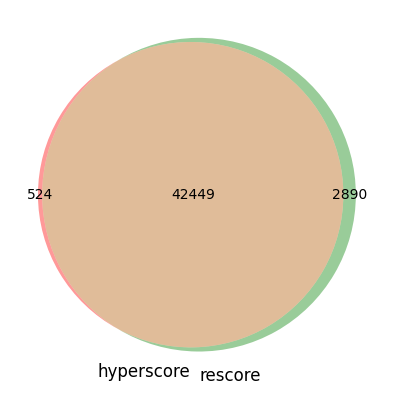

In [27]:
from matplotlib_venn import venn2

venn2([set(TARGET.match_idx), set(TARGET_rescored.match_idx)], ("hyperscore", "rescore"))
plt.show()

### Try different ML models from sklearn and check their performance

In [28]:
from sklearn.svm import SVC
from sagepy.rescore.rescore import rescore_psms

# try out an SVC, the model employed by percolator
model = SVC(probability=True)

psms_svc = rescore_psms(
    psm_collection=psm_list,
    model=model,
    num_splits=3,
    verbose=True
)

Re-scoring PSMs: 100%|████████████████████████████████████████████████| 3/3 [00:38<00:00, 12.95s/it]


In [29]:
# create pandas table from psms
PSM_pandas_rescored = peptide_spectrum_match_collection_to_pandas(psms_svc)

# calculate q-values to get inital "good" hits
PSM_q_rescore = target_decoy_competition_pandas(PSM_pandas_rescored, score="re_score", method="peptide_psm_peptide")
PSM_pandas_dropped = PSM_pandas_rescored.drop(columns=["q_value", "score"])

# merge data with q-values
TDC = pd.merge(PSM_q_rescore, PSM_pandas_dropped, left_on=["spec_idx", "match_idx", "decoy"], right_on=["spec_idx", "match_idx", "decoy"])

# select best positive examples
TARGET_rescored_svm = TDC[(TDC.decoy == False) & (TDC.q_value <= 0.01)]
DECOY = TDC[TDC.decoy]

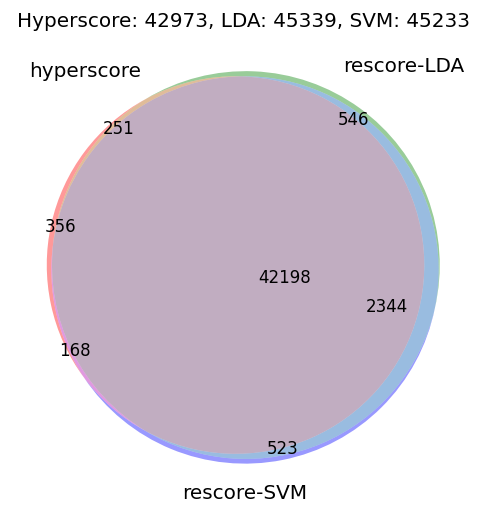

In [30]:
from matplotlib_venn import venn3

plt.figure(figsize=(5, 5), dpi=120)
plt.title(f"Hyperscore: {len(set(TARGET.match_idx))}, LDA: {len(set(TARGET_rescored.match_idx))}, SVM: {len(set(TARGET_rescored_svm.match_idx))}")
venn3([set(TARGET.match_idx), set(TARGET_rescored.match_idx), set(TARGET_rescored_svm.match_idx)], ("hyperscore", "rescore-LDA", "rescore-SVM"))
plt.show()

### Use mokapot to re-scoe PSMs and compare to best results

In [31]:
import mokapot
from imspy.timstof.dbsearch.utility import transform_psm_to_pin

# create a PIN file from the PSMs
PSM_pin = transform_psm_to_pin(PSM_pandas)
PSM_pin.to_csv("PSMs.pin", index=False, sep="\t")

psms_moka = mokapot.read_pin("PSMs.pin")
results, models = mokapot.brew(psms_moka)

results.to_txt(dest_dir="")

/home/administrator/Documents/promotion/ENV-11/lib/python3.11/site-packages/mokapot/parsers/pin.py:238: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  yield psms.apply(pd.to_numeric, errors="ignore")


['mokapot.psms.txt', 'mokapot.peptides.txt']

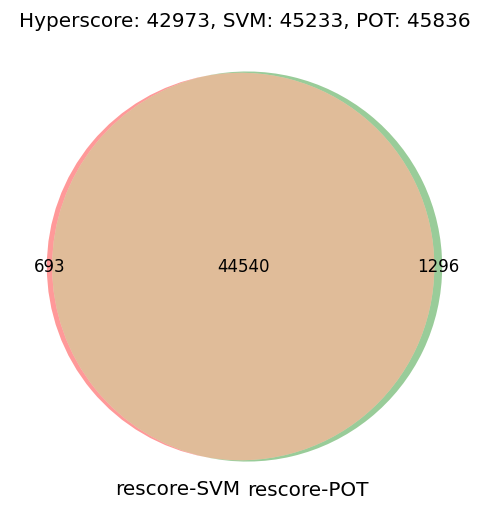

In [41]:
moka_peptides = pd.read_table("mokapot.peptides.txt")
peptides = set(moka_peptides[moka_peptides["mokapot q-value"] <= 0.01].Peptide)

plt.figure(figsize=(5, 5), dpi=120)
plt.title(f"Hyperscore: {len(set(TARGET.match_idx))}, SVM: {len(set(TARGET_rescored_svm.match_idx))}, POT: {len(peptides)}")
venn2([set(TARGET_rescored_svm.match_idx), peptides], ("rescore-SVM", "rescore-POT"))
plt.show()